This Notebook contains 4 example queries for the MongoDB database. 

In [29]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv
from bson.objectid import ObjectId
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

load_dotenv()  # take environment variables from .env.

# client = load_env()
client = MongoClient('mongodb+srv://' + os.getenv('MongoUser') + ':' + os.getenv('MongoPassword') + '@mongodbcluster.n6cun7v.mongodb.net/')

In [30]:
# define collection names
db = client['MongoDB-Database']
gateways_collection = db['gateways']
measures_collection = db['measures']
tags_collection = db['tags']

# color will be used in visualizations
mongodb_green = "#4DB33D"

# Abfrage 1: In welcher Abteilung halten sich die meisten Kunden auf?
Technisch wird ermittelt, wie viele Tags sich aktuell an welchem Gateway befinden.

In [31]:
pipeline = [
    # Stage 1: Unwind the tags_assigned array
    {"$unwind": "$tags_assigned"},
    # Stage 2: Group by gateway_id and count the number of tags_assigned
    {
        "$group": {
            "_id": "$_id",
            "gateway_id": {"$first": "$_id"},
            "tag_count": {"$sum": 1}
        }
    },
    # Stage 3: Sort the result by tag_count in descending order
    {"$sort": {"tag_count": 1}},
    # Stage 4: Project the fields for the final result
    {"$project": {"_id": 0, "gateway_id": 1, "tag_count": 1}}
]


# Execute the aggregation query
results = list(gateways_collection.aggregate(pipeline))

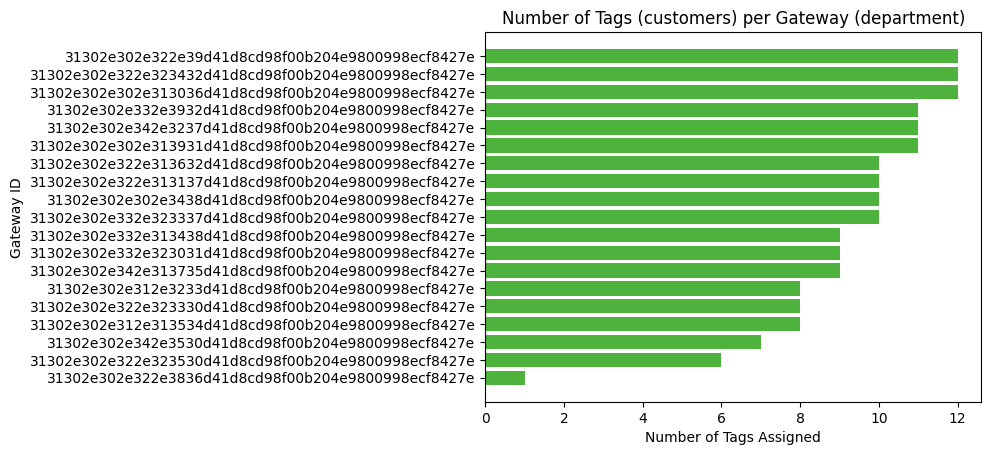

In [32]:
# Visualisierung der Abfrage
# extract data for plotting
gateway_ids = [result["gateway_id"] for result in results]
tag_counts = [result["tag_count"] for result in results]
mongodb_green = "#4DB33D"

# Create a horizontal bar chart
plt.barh(gateway_ids, tag_counts, color=mongodb_green)
plt.xlabel('Number of Tags Assigned')
plt.ylabel('Gateway ID')
plt.title('Number of Tags (customers) per Gateway (department)')
plt.show()

# Abfrage 2: Welche Abteilung hat das höchste Kundeninteresse? 
Im Sachzusammenhang des Einkaufladens werden große Beschleunigungswerte als Stoppen und wieder Bewegen des Einkaufswagens gedeutet. Höhere durchschnittliche Beschleunigungswerte stellen somit ein höheres Kundeninteresse dar. 
Im Sachkontext wird als "vorne" die X-Richtung definiert, womit ausschließlich die acc_x Werte visualisiert werden.

In [33]:
pipeline = [
    # Stage 1: Group by gateway_id and calculate average for each field
    {
        "$group": {
            "_id": "$gateway_id",
            "avg_acc_x": {"$avg": "$acc_x"},
            "avg_acc_y": {"$avg": "$acc_y"},
            "avg_acc_z": {"$avg": "$acc_z"}
        }
    }
]

# Execute the aggregation query
results = list(measures_collection.aggregate(pipeline))

# Print the results
for result in results:
    gateway_id = result["_id"]  # Use "_id" as it is the grouped field
    avg_acc_x = result["avg_acc_x"]
    avg_acc_y = result["avg_acc_y"]
    avg_acc_z = result["avg_acc_z"]
    print(f"Gateway ID: {gateway_id}, Average acc_x: {avg_acc_x}, Average acc_y: {avg_acc_y}, Average acc_z: {avg_acc_z}")

Gateway ID: 31302e302e302e3438d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.9531012578589, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e313137d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e323530d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.97893897890495, Average acc_y: -4.01175014099655, Average acc_z: 9.81
Gateway ID: 31302e302e322e313632d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.9531012578589, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e39d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e332e323031d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e342e3237d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 

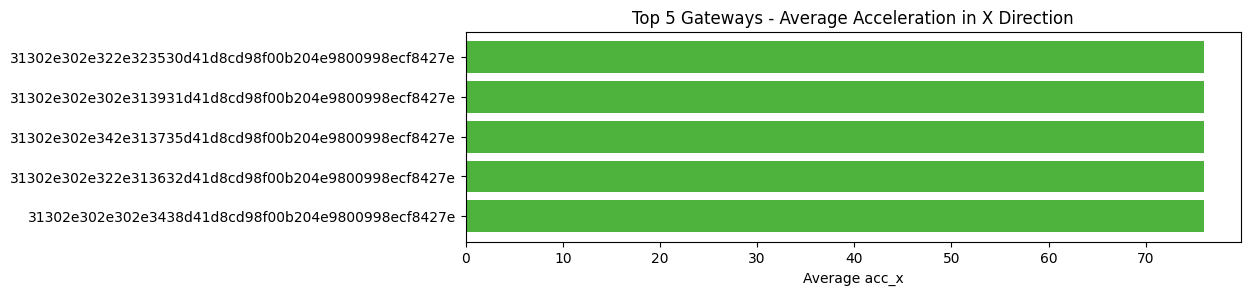

In [34]:
# Visualization
# Extract data for visualization
gateway_ids = [result["_id"] for result in results]
avg_acc_x_values = [result["avg_acc_x"] for result in results]
#avg_acc_y_values = [result["avg_acc_y"] for result in results]
#avg_acc_z_values = [result["avg_acc_z"] for result in results]

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by average acceleration values and filter on top 5 results
df_sorted_x = df.sort_values(by='avg_acc_x', ascending=False).head(5).sort_values(by='avg_acc_x', ascending=True)
#df_sorted_y = df.sort_values(by='avg_acc_y', ascending=False).head(5).sort_values(by='avg_acc_y', ascending=True)
#df_sorted_z = df.sort_values(by='avg_acc_z', ascending=False).head(5).sort_values(by='avg_acc_z', ascending=True)

# Plotting horizontal bar graphs for top 5 gateways
plt.figure(figsize=(10, 6))

# Plot for acc_x
plt.subplot(2, 1, 1)
plt.barh(df_sorted_x['_id'], df_sorted_x['avg_acc_x'], color=mongodb_green)
plt.yticks(df_sorted_x['_id'], df_sorted_x['_id'])
plt.xlabel('Average acc_x')
plt.title('Top 5 Gateways - Average Acceleration in X Direction')

# Plot for acc_y
#plt.subplot(2, 1, 2)
#plt.barh(df_sorted_y['_id'], df_sorted_y['avg_acc_y'], color=mongodb_green)
#plt.yticks(df_sorted_y['_id'], df_sorted_y['_id'])
#plt.xlabel('Average acc_y')
#plt.title('Top 5 Gateways - Average Acceleration in Y Direction')

#plt.tight_layout()
plt.show()

# Abfrage 3: In welcher Abteilung gibt es viele Zusammenstöße mit Regalen? 
Uns interessiert ebenfalls die Raumgestaltung der einzelnen Abteilungen. Wir definieren "Zusammenstöße mir Regalen" anhand hoher Beschleunigungswerte. Als Grenze haben wir 200 m/s² festgelegt, was ein wenig mehr als 20G sind. Es werden erneut lediglich die acc_x Werte visualisiert.

In [35]:
pipeline = [
    # Stage 1: Filter documents where acc_x is above the threshold
    {
        "$match": {
            "acc_x": {"$gt": 200}
        }
    },
    # Stage 2: Group by gateway_id and count the documents
    {
        "$group": {
            "_id": "$gateway_id",
            "count_acc_x_above_20g": {"$sum": 1}
        }
    }
]

# Execute the aggregation query
results_acc_x = list(measures_collection.aggregate(pipeline))

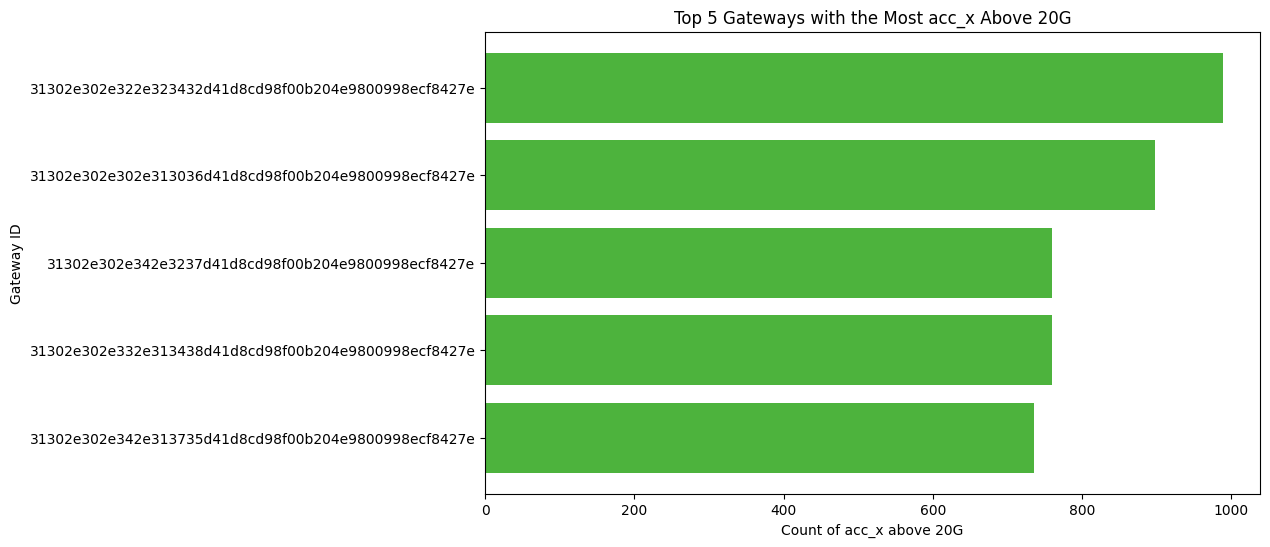

In [36]:
# convert the results to a pandas DataFrame
df_acc_x_above_threshold = pd.DataFrame(results_acc_x)

# Sort the DataFrame by the count values and filter on top 5 results
df_sorted_acc_x = df_acc_x_above_threshold.sort_values(by='count_acc_x_above_20g', ascending=False).head(5).sort_values(by='count_acc_x_above_20g', ascending=True)

plt.figure(figsize=(10, 6))
# Plot x data
plt.barh(df_sorted_acc_x['_id'], df_sorted_acc_x['count_acc_x_above_20g'], color=mongodb_green)
plt.xlabel('Count of acc_x above 20G')
plt.ylabel('Gateway ID')
plt.title('Top 5 Gateways with the Most acc_x Above 20G')
plt.show()


# Wie lange verbringt ein kunde in einer Abteilung?
Technisch ist zu ermitteln, zu welchem Zeitpunkt Gateway-Tag-Wechsel stattfinden, um anschließend die durchschnittliche Zeit einer Gateway-Tag-Verbindung zu ermitteln. Dazu sind mehrere Schritte nötig. di unteren Schritte sind entsprechend im Code kommentiert. 

1. Die Daten werden abgefragt und nach recorded_time sortiert
2. Die Differenz der recorded_time zur nun sortierten vorherigen Zeile, gruppiert nach Gateway-ID und Tag-ID, wird ermittelt
3. Alle Differenzen, die größer als 1 Minute sind, werden als "Connection Events" und damit als neue Session definiert (1 in der Spalte new_connection_event)
4. Die Spalte connection_event_group kumuliert die Summe der Connection Events, ebenfalls gruppiert nach Gateway-ID und Tag-ID. Jede connection_event_group stellt eine Session der Verbindung zwischen Gateway-ID und Tag-ID dar. 
5. Für jede Gruppierung aus gateway_id und connection_event_group kann eine Durchschnittszeitszeit ermittelt werden.
6. Anschließend kann auf Basis dieser Session-Durchschnittszeiten die Durchschnittszeit des Gateways allgemein ermittelt werden. 

In [37]:
# Step 1
# Define a projection to retrieve only the desired fields
projection = {
    "_id": 0,  # Exclude the MongoDB document ID
    "recorded_time": 1,
    "gateway_id": 1,
    "tag_id": "$tag_address",  # Assuming tag_id is stored in the tag_address field
}

# Fetch documents with the specified projection
cursor = measures_collection.find({}, projection)

# Convert the cursor to a list and then to a DataFrame
measures_df = pd.DataFrame(list(cursor))

# Convert recorded_time to datetime format
measures_df["recorded_time"] = pd.to_datetime(measures_df["recorded_time"])

# Sort the DataFrame by recorded_time
measures_df.sort_values(by="recorded_time", inplace=True)

# Step 2
# Calculate the time difference between consecutive records for the same tag_id and gateway_id
measures_df["time_diff"] = measures_df.groupby(["tag_id", "gateway_id"])["recorded_time"].diff()

# Step 3
# Identify distinct connection events (cases where the time difference is greater than 1 minute)
time_threshold = pd.Timedelta(minutes=1)
measures_df["new_connection_event"] = (measures_df["time_diff"] > time_threshold).astype(int)

# Step 4
# Cumulative sum of new_connection_event to create groups
measures_df["connection_event_group"] = measures_df.groupby("gateway_id")["new_connection_event"].cumsum()

# Step 5
# Calculate the total connection time for each gateway_id and connection_event_group
total_connection_time = measures_df.groupby(["gateway_id", "connection_event_group"])["recorded_time"].agg(["min", "max"]).reset_index()

# Step 6
# Calculate the average connection time for each gateway_id
average_connection_time = total_connection_time.copy()
average_connection_time["duration"] = average_connection_time["max"] - average_connection_time["min"]
average_connection_time["average_connection_time"] = average_connection_time["duration"] / pd.Timedelta(seconds=1)  # Convert to seconds for average

                                           gateway_id  average_connection_time
16  31302e302e342e313735d41d8cd98f00b204e9800998ec...                  434.424
6   31302e302e322e313632d41d8cd98f00b204e9800998ec...                  434.335
11   31302e302e322e39d41d8cd98f00b204e9800998ecf8427e                  434.249
0   31302e302e302e313036d41d8cd98f00b204e9800998ec...                  434.214
8   31302e302e322e323432d41d8cd98f00b204e9800998ec...                  434.214
14  31302e302e332e323337d41d8cd98f00b204e9800998ec...                  434.197
2   31302e302e302e3438d41d8cd98f00b204e9800998ecf8...                  434.197
5   31302e302e322e313137d41d8cd98f00b204e9800998ec...                  434.197
1   31302e302e302e313931d41d8cd98f00b204e9800998ec...                  434.197
15  31302e302e332e3932d41d8cd98f00b204e9800998ecf8...                  434.197
17  31302e302e342e3237d41d8cd98f00b204e9800998ecf8...                  434.196
13  31302e302e332e323031d41d8cd98f00b204e9800998ec..

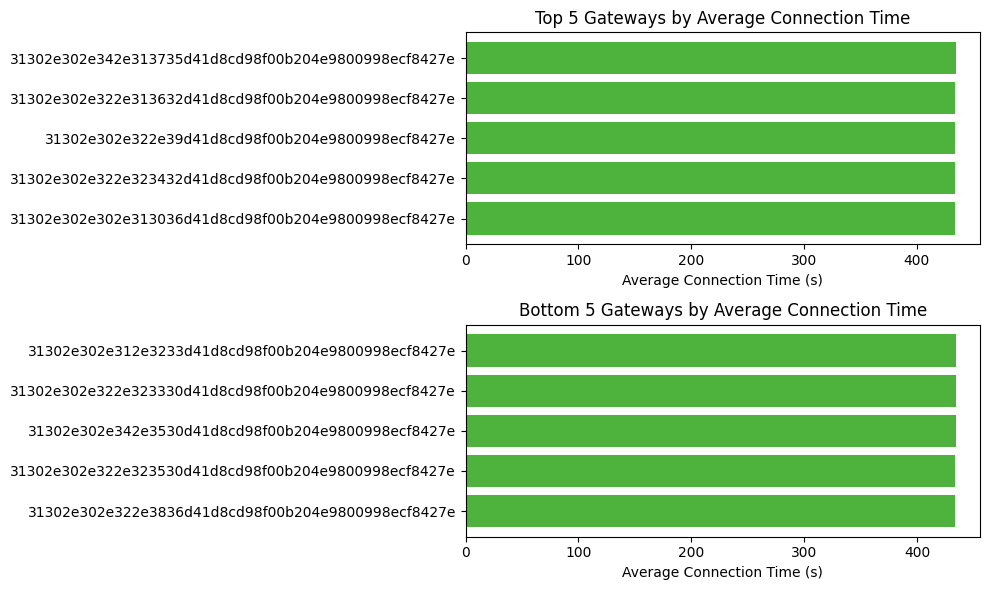

In [38]:
'''Below is the visualisation code'''
# Sort the DataFrame by average_connection_time in descending order
average_connection_time_sorted = average_connection_time.sort_values(by='average_connection_time', ascending=False)

# Group by gateway_id and calculate the average connection time
grouped_gateways = average_connection_time_sorted.groupby('gateway_id')['average_connection_time'].mean().reset_index()

# Sort the grouped DataFrame by average connection time in descending order
grouped_gateways_sorted = grouped_gateways.sort_values(by='average_connection_time', ascending=False)

# Display the result
print(grouped_gateways_sorted[["gateway_id", "average_connection_time"]])

# Top 5 gateways
top5_gateways = grouped_gateways_sorted.head(5).sort_values(by='average_connection_time', ascending=True)

# Bottom 5 gateways
bottom5_gateways = grouped_gateways_sorted.tail(5).sort_values(by='average_connection_time', ascending=True)

# Visualization
plt.figure(figsize=(10, 6))

# Top 5
plt.subplot(2, 1, 1)
plt.barh(top5_gateways['gateway_id'], top5_gateways['average_connection_time'], color=mongodb_green)
plt.yticks(top5_gateways['gateway_id'], top5_gateways['gateway_id'])
plt.xlabel('Average Connection Time (s)')
plt.title('Top 5 Gateways by Average Connection Time')

# Bottom 5
plt.subplot(2, 1, 2)
plt.barh(bottom5_gateways['gateway_id'], bottom5_gateways['average_connection_time'], color=mongodb_green)
plt.yticks(bottom5_gateways['gateway_id'], bottom5_gateways['gateway_id'])
plt.xlabel('Average Connection Time (s)')
plt.title('Bottom 5 Gateways by Average Connection Time')

# Adjust layout
plt.tight_layout()
plt.show()